<a href="https://colab.research.google.com/github/NavinAnto-03/AI-Projects/blob/main/Ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Saving file_example_MP4_1920_18MG.mp4 to file_example_MP4_1920_18MG.mp4
Converted Audio Files: ['file_example_MP4_1920_18MG.wav']
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 51.8660
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 51.5729
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 50.1076
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 49.0819
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 50.8587
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 47.8689
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 46.8419
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 44.5480
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 45.5018
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 45.1110


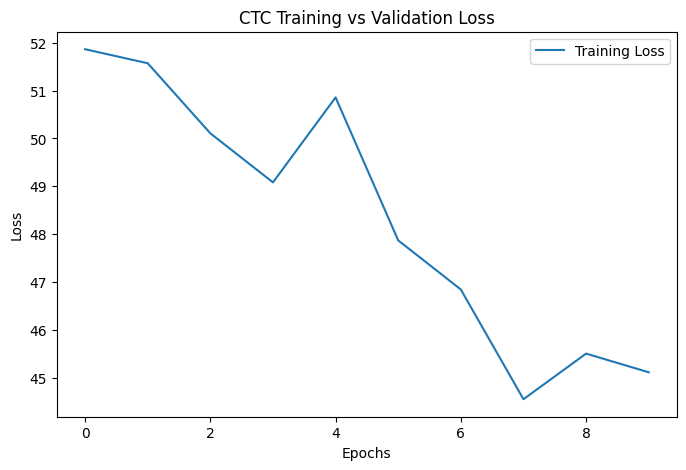

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Predicted for file_example_MP4_1920_18MG.wav → h


In [ ]:
!pip install librosa pydub tensorflow

import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import files
from pydub import AudioSegment
import os

uploaded = files.upload()

audio_files = []
for fname in uploaded.keys():
    name, ext = os.path.splitext(fname)
    ext = ext.lower()
    wav_file = name + ".wav"
    if ext != ".wav":
        sound = AudioSegment.from_file(fname)
        sound.export(wav_file, format="wav")
        audio_files.append(wav_file)
    else:
        audio_files.append(fname)

print("Converted Audio Files:", audio_files)

labels = [os.path.splitext(f)[0].lower() for f in audio_files]

SAMPLE_RATE = 16000
MAX_AUDIO_LENGTH = 8000
NUM_MFCC = 13

VOCAB = list("abcdefghijklmnopqrstuvwxyz")
char_to_index = {c: i + 1 for i, c in enumerate(VOCAB)}
index_to_char = {i + 1: c for i, c in enumerate(VOCAB)}

def extract_features(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(signal) > MAX_AUDIO_LENGTH:
        signal = signal[:MAX_AUDIO_LENGTH]
    else:
        signal = np.pad(signal, (0, MAX_AUDIO_LENGTH - len(signal)))
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=NUM_MFCC)
    return mfcc.T

X = []
y = []
input_lengths = []
label_lengths = []

for file, label in zip(audio_files, labels):
    features = extract_features(file)
    X.append(features)
    label_seq = [char_to_index[c] for c in label if c in char_to_index]
    y.append(label_seq)
    input_lengths.append(len(features))
    label_lengths.append(len(label_seq))

X = pad_sequences(X, dtype="float32", padding="post")
y = pad_sequences(y, padding="post")

inputs = Input(shape=(X.shape[1], X.shape[2]))
x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
outputs = TimeDistributed(Dense(len(VOCAB) + 1, activation="softmax"))(x)
model = Model(inputs, outputs)

labels_in = tf.keras.layers.Input(name="the_labels", shape=(y.shape[1],), dtype="int32")
input_len = tf.keras.layers.Input(name="input_length", shape=(1,), dtype="int32")
label_len = tf.keras.layers.Input(name="label_length", shape=(1,), dtype="int32")

def ctc_loss(args):
    y_pred, labels, input_len, label_len = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_len, label_len)

loss_out = tf.keras.layers.Lambda(ctc_loss, output_shape=(1,), name="ctc")(
    [outputs, labels_in, input_len, label_len]
)

ctc_model = Model(inputs=[inputs, labels_in, input_len, label_len], outputs=loss_out)
ctc_model.compile(optimizer="adam", loss={"ctc": lambda y_true, y_pred: y_pred})

input_len_arr = np.array(input_lengths).reshape(-1, 1)
label_len_arr = np.array(label_lengths).reshape(-1, 1)

if len(X) > 1:
    history = ctc_model.fit(
        x=[X, y, input_len_arr, label_len_arr],
        y=np.zeros(len(X)),
        batch_size=2,
        epochs=10,
        validation_split=0.5
    )
else:
    history = ctc_model.fit(
        x=[X, y, input_len_arr, label_len_arr],
        y=np.zeros(len(X)),
        batch_size=1,
        epochs=10
    )

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
if "val_loss" in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CTC Training vs Validation Loss')
plt.legend()
plt.show()

y_pred = model.predict(X)
decoded, _ = tf.keras.backend.ctc_decode(
    y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], greedy=True
)

for i, seq in enumerate(decoded[0].numpy()):
    text = ''.join([index_to_char.get(c, '') for c in seq if c > 0])
    print(f"Predicted for {audio_files[i]} → {text}")
